# MIS 583 A7 Semantic Segmentation on BCSS

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 鄔仁迪, B104020009.

## Overview

- Semantic segmentation is a computer vision task that aims to classify each pixel in an image into specific objects or regions.

- In this assignment, you will implement a segmentor to classify the specific types of breast cancer lesions.

- The segmentor implemented in this assignment is U-Net, and you are required to construct it from scratch


## Kaggle Competition
Kaggle is an online community of data scientists and machine learning practitioners. Kaggle allows users to find and publish datasets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

This assignment use kaggle to calculate your grade.  
Please use this [**LINK**](https://www.kaggle.com/t/13040d09b42940ba90f96cca324ee90d) to join the competition.

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## How to Get Data

請先到共用雲端硬碟將檔案 `BCSS.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1uW9SInf6jrF5YUCjf-2ObxLolYYEb2Np/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

## Unzip Data

解壓縮 `BCSS.zip` 

+ `train` : 包含了train的所有圖片
+ `val` : 包含了val的所有圖片
+ `test` : 包含了test的所有圖片
+ `train_mask` : 包含了train的所有mask
+ `val_mask` : 包含了val所有mask
+ `test_mask` : 包含了test的所有mask


其中`train`的圖片 30760 張，`val`的圖片 5429 張，`test` 的圖片 4021 張。

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [2]:
# !unzip -qq C:/Users/eddie/GitHub/Deep-Learning/PyTorch/Class/pytorch107/BCSS.zip

# Import Libraries

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing

#### Verify that the paths to the image and mask are correct, and plot the position of the mask on the image.

First, the code establishes DataFrames for the paths of training and validation images, including their corresponding mask paths.

Second, it presents the total number of images in both the training and validation sets.

Third, the code loads a sample training image and its associated mask, visually demonstrating the image and the applied mask in a graphical representation.

In [4]:
TRAIN_IMAGE_PATH = 'BCSS/train/'
VAL_IMAGE_PATH = 'BCSS/val/'
TRAIN_MASK_PATH = 'BCSS/train_mask/'
VAL_MASK_PATH = 'BCSS/val_mask/'

In [5]:
n_classes = 3

def create_df(IMAGE_PATH):
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

train_df = create_df(TRAIN_IMAGE_PATH)
val_df = create_df(VAL_IMAGE_PATH)


print('Total Train Images: ', len(train_df))
print('Total Val Images: ', len(val_df))

Total Train Images:  30760
Total Val Images:  5429


In [6]:
X_train = train_df['id'].to_numpy()
X_val = val_df['id'].to_numpy()

Image Size (224, 224, 3)
Mask Size (224, 224)


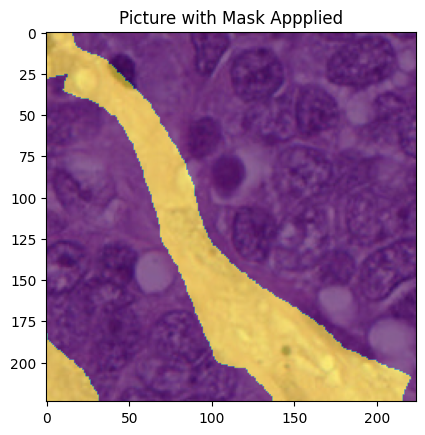

In [7]:
img = Image.open(TRAIN_IMAGE_PATH + train_df['id'][100] + '.png')
mask = Image.open(TRAIN_MASK_PATH + train_df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Loading the Dataset

Define the BCSSDataset for loading the dataset, where each sample comprises an image and its corresponding mask

Build a classs inherit `torch.utils.data.Dataset`.
  
Implement `__init__`, `__getitem__` and `__len__` 3 functions.  

Some operations could be there: setting location of dataset, the method of reading data, label of dataset or transform of dataset.

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

In [8]:
class BCSSDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
            
        return img, mask

## Data augmentation 

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

PyTorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/vision/stable/transforms.html)

In [9]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# For TRAIN
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for training, find the composition to get better result #
########################################################################
transforms_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5)
])
########################################################################
#                           End of your code                           #
########################################################################

# For VAL
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for validate and test,                                  #
#  NOTICE some operation we usually not use in this part               #
########################################################################
transforms_val = A.Compose([
    # Usually, validation transforms are simpler and do not include augmentation
])
########################################################################
#                           End of your code                           #
########################################################################

#datasets
train_set = BCSSDataset(TRAIN_IMAGE_PATH, TRAIN_MASK_PATH, X_train, mean, std, transforms_train)
val_set = BCSSDataset(VAL_IMAGE_PATH, VAL_MASK_PATH, X_val, mean, std, transforms_val)

#dataloader
batch_size= 10

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

In [10]:
train_set[0]

(tensor([[[ 1.2728,  1.3413,  1.5297,  ...,  1.1700,  1.2214,  1.2385],
          [ 1.3242,  1.3927,  1.6153,  ...,  1.1700,  1.2214,  1.2214],
          [ 1.4440,  1.5297,  1.7523,  ...,  1.1700,  1.1872,  1.2043],
          ...,
          [ 1.1187,  1.0673,  0.9303,  ...,  0.4679,  0.4166,  0.3652],
          [ 1.1187,  1.0331,  0.8276,  ...,  0.2282,  0.2111,  0.1768],
          [ 1.0844,  0.9988,  0.7762,  ...,  0.1426,  0.1254,  0.0912]],
 
         [[ 0.7479,  0.8704,  1.2031,  ...,  0.8704,  0.9230,  0.9055],
          [ 0.8704,  1.0105,  1.3431,  ...,  0.8179,  0.8880,  0.8704],
          [ 1.1681,  1.2906,  1.6057,  ...,  0.7129,  0.8004,  0.8179],
          ...,
          [ 0.3803,  0.2927,  0.0826,  ..., -0.4426, -0.4251, -0.4426],
          [ 0.3102,  0.2052, -0.0924,  ..., -0.6527, -0.6176, -0.6352],
          [ 0.2752,  0.1352, -0.1800,  ..., -0.7402, -0.6877, -0.7052]],
 
         [[ 2.0300,  2.0823,  2.2391,  ...,  1.8034,  1.8208,  1.8208],
          [ 2.0997,  2.1520,

# U-net

U-net is a fully convolution neural network for image semantic segmentation. Consist of encoder and decoder parts connected with skip connections. Encoder extract features of different spatial resolution (skip connections) which are used by decoder to define accurate segmentation mask. Use concatenation for fusing decoder blocks with skip connections.


![image](https://hackmd.io/_uploads/rJXtsY_Up.png)

In [11]:
class DoubleConv(nn.Module):
    """
    Block with two convolutional blocks
    """

    def __init__(self, in_channels, out_channels, mid_channels=None):
        """
        Double convolution

        :param in_channels: number of in channels for first conv layer
        :param out_channels: number of out channels for last conv layer
        :param mid_channels: number of out channels for first conv layer
        """
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        ########################################################################
        #  TODO:                                                               #
        #  write model that contains 2 conv layer with batch normalization     #
        #  and relu activation function                                        #
        ########################################################################
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """
    Block for down path
    """

    def __init__(self, in_channels, out_channels):
        """
        Down block

        :param in_channels: number of in channels for double conv block
        :param out_channels: number of out channels for double conv block
        """
        super().__init__()
        ########################################################################
        #  TODO:                                                               #
        #  write model which contains pooling and double conv block            #
        ########################################################################
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    Block for up path
    """

    def __init__(self, in_channels, out_channels):
        """
        Down block

        :param in_channels: number of in channels for transpose convolution
        :param out_channels: number of out channels for double conv block
        """
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2): 
        
        #########################################################################################
        # 1. Up-sample the input tensor using transpose convolution                             #
        # 2. Calculate the difference in height and width between x2 and the up-sampled x1      #
        # 3. Pad the up-sampled x1 to match the size of x2                                      #
        # 4. Concatenate x2 and the up-sampled x1 along the channel dimension                   #
        #########################################################################################
        # Upsample x1
        x1 = self.up(x1)

        # Calculate size differences
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        # Padding x1 to match the size of x2
        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        # Concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)

        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Final convolution block

        :param in_channels: number of in channels for conv layer
        :param out_channels: number of out channels for conv layer
        """
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [12]:
class UNet(nn.Module):
    """
    UNet model
    """

    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        #############################################################
        #  implement the model according to the UNet architecture   #
        ############################################################# 
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Contracting Path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Expansive Path
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Output Layer
        logits = self.outc(x)
        return logits
        #############################################################
        #                   End of your code                        #
        #############################################################

In [13]:
model = UNet(n_channels=3, n_classes=3)

In [14]:
model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

# Training

In this section, you will implement some functions in your training loop. There are several crucial functions you need to implement:

- Pixel Accuracy: Pixel Accuracy measures the percentage of correctly predicted pixels out of the total pixels in the image

- mIoU (Mean Intersection over Union): mIoU evaluates the spatial overlap between the predicted and ground truth segmentation masks for multiple classes.

- Dice Loss: Dice Loss quantifies the dissimilarity between the predicted and ground truth masks, emphasizing the agreement between the two masks

Try to use labeled data design and train a segmentor (Unet) from scratch to predict the mask of a breast cancer lesions image. 

In [15]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        #############################################################################################################
        #  1. Convert the output to class predictions using argmax after applying softmax                           # 
        #  2. Create a tensor of binary values indicating correct predictions                                       #
        #  3. Calculate accuracy by dividing the number of correct predictions by the total number of predictions   #
        #############################################################################################################
        # Apply softmax and then argmax to get class predictions
        predictions = torch.argmax(F.softmax(output, dim=1), dim=1)

        # Create a binary tensor indicating correct predictions
        correct_predictions = (predictions == mask)

        # Calculate accuracy
        accuracy = torch.sum(correct_predictions).item() / correct_predictions.numel()
        #############################################################################################################
        #                                      End of your code                                                     #
        #############################################################################################################
    return accuracy

## mIoU

mean Intersection over Union (mIoU), a metric used to evaluate the performance of a segmentation model. It takes predicted masks and ground truth masks as input, computes the IoU for each class, and returns the average IoU across all classes. 

![image](https://hackmd.io/_uploads/SkLIbhFL6.png)

In [16]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=3):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:

                #############################################################################################################
                #  Calculate the intersection of the true positive pixels for the current class                             # 
                #  Calculate the union of the true positive and false negative pixels for the current class                 #
                #############################################################################################################
                # Calculate the intersection and union
                intersect = torch.logical_and(true_class, true_label).sum().item()
                union = torch.logical_or(true_class, true_label).sum().item()
                #############################################################################################################
                #                                      End of your code                                                     #
                #############################################################################################################
                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

## Dice Loss

Dice loss is based on Sørensen-Dice coefficient. It measures the overlap between the predicted and target segmentation masks. Dice loss provides a differentiable and smooth measure of segmentation accuracy.

${DiceLoss}(y, \bar p) = 1 - \cfrac{(2y\bar p + \epsilon)}{(y + \bar p + \epsilon)}$ 

- $y$ represents the ground truth mask.
- $\bar p$ represents the predicted mask.
- $\epsilon$ is a small constant added for numerical stability.

In [17]:
class DiceLoss(nn.Module):
    """
    Dice loss
    """

    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, eps=1e-6):
        """
        Calculation of dice loss

        :param inputs: model predictions
        :param targets: target values
        :param eps: stability factor, defaults to 1e-6
        :return: loss value
        """
        # 
        #######################################
        #        implement dice loss          #                                                                      
        #######################################
        # Apply softmax to the inputs
        inputs = torch.softmax(inputs, dim=1)

        # Create the one-hot encoding of targets
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1])
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()

        # Flatten inputs and targets
        inputs_flat = inputs.view(inputs.shape[0], inputs.shape[1], -1)
        targets_flat = targets_one_hot.view(targets_one_hot.shape[0], targets_one_hot.shape[1], -1)

        # Calculate intersection and union
        intersection = torch.sum(inputs_flat * targets_flat, dim=2)
        total = torch.sum(inputs_flat, dim=2) + torch.sum(targets_flat, dim=2)

        # Calculate dice score for each class and average
        dice = (2. * intersection + eps) / (total + eps)
        dice = dice.mean(dim=1)  # Average over classes
        #######################################
        #          End of your code           #                              
        #######################################
        return 1.0 - dice.mean()

# Training loop

Call train function in a loop.  
Take a break and wait.

In [18]:
from ema_pytorch import EMA

alpha = 0.999  # decay factor for EMA
global_step = 0  # to keep track of the number of steps

# Initialize EMA with your model and decay rate
# Initialize EMA
ema = EMA(
    model=model,
    beta=0.9999,  # Decay rate for EMA
    update_after_step=100,  # Number of steps after which to start updating EMA
    update_every=10,  # Frequency of updates (every 10 steps)
    # Other parameters as needed
)

ema.to(device)

EMA(
  (online_model): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padd

In [19]:
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    """Save the current training state as a checkpoint."""
    torch.save(state, filename)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion1, criterion2, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    ema_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    ema_iou = []; ema_acc = []
    lrs = []
    min_loss = np.inf
    max_iou = 0
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    
    # Check if there's a checkpoint to resume from
    if os.path.exists('last_checkpoint.pth.tar'):
        checkpoint = torch.load('last_checkpoint.pth.tar')
        model.load_state_dict(checkpoint['model_state'])
        ema.load_state_dict(checkpoint['ema_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        scheduler.load_state_dict(checkpoint['scheduler_state'])
        train_losses = checkpoint['train_losses']
        test_losses = checkpoint['test_losses']
        ema_losses = checkpoint['ema_losses']
        val_iou = checkpoint['val_iou']
        val_acc = checkpoint['val_acc']
        train_iou = checkpoint['train_iou']
        train_acc = checkpoint['train_acc']
        ema_iou = checkpoint['ema_iou']
        ema_acc = checkpoint['ema_acc']
        lrs = checkpoint['lrs']
        decrease = checkpoint['decrease']
        not_improve = checkpoint['not_improve']
        min_loss = checkpoint['min_loss']
        max_iou = checkpoint['max_iou']
        start_epoch = checkpoint['epoch']
    else:
        start_epoch = 0
    
    
    for e in range(start_epoch, epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        train_loop = tqdm(train_loader, desc='Training', leave=True)
        for i, data in enumerate(train_loop):
            #training phase
            ########################################################################
            # TODO: Forward, backward and optimize                                 #
            # 1. process input through the network                                 #
            # 2. compute the two losses                                            #
            # 3. calculate mIoU and pixel accuracy                                   #
            # 4. propagate gradients back into the network’s parameters            #
            # 5. update the weights of the network                                 #
            # 6. reset gradient                                                    #
            ########################################################################
            image, mask = data
            image = image.to(device)
            mask = mask.to(device)

            # 1. process input through the network
            output = model(image)

            # 2. Compute the two losses
            loss = criterion1(output, mask) + criterion2(output, mask)

            # 3. Calculate mIoU and pixel accuracy
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            # 4. Propagate gradients back into the network’s parameters
            loss.backward()

            # 5. Update the weights of the network
            optimizer.step()

            # 6. Reset gradient
            optimizer.zero_grad()

            # Show Current Mean Loss, Mean mIoU, Mean Accuracy to tqdm
            train_loop.set_postfix(loss=(running_loss + loss.item())/(i+1), mIoU=iou_score/(i+1), acc=accuracy/(i+1))
            
            # Update EMA after every training step
            ema.update()
            ########################################################################
            #                           End of your code                           #
            ########################################################################
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            
            ema_loss = 0
            ema_accuracy = 0
            ema_iou_score = 0

            val_loop = tqdm(val_loader, desc='Validation', leave=True)
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(val_loop):
                    ########################################################################
                    # TODO: Forward, backward and optimize                                 #
                    # 1. process input through the network                                 #
                    # 2. compute the two losses                                            #
                    # 3. caluate mIoU and piexl accuracy                                   #
                    # 4. save this batch's loss into test_loss                             #
                    ########################################################################
                    image, mask = data
                    image = image.to(device)
                    mask = mask.to(device)

                    # 1. Process input through the network
                    output = model(image)

                    # 2. Compute the two losses
                    loss = criterion1(output, mask) + criterion2(output, mask)

                    # 3. Calculate mIoU and pixel accuracy
                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)

                    # 4. Save this batch's loss into test_loss
                    test_loss += loss.item()
                    
                    # Get exponential moving average of model predictions
                    output = ema(image)
                    loss = criterion1(output, mask) + criterion2(output, mask)
                    ema_iou_score += mIoU(output, mask)
                    ema_accuracy += pixel_accuracy(output, mask)
                    ema_loss += loss.item()

                    # Show Current Mean Loss, Mean mIoU, Mean Accuracy to tqdm
                    val_loop.set_postfix(loss=test_loss/(i+1), mIoU=val_iou_score/(i+1), acc=test_accuracy/(i+1), ema_loss=ema_loss/(i+1), ema_mIoU=ema_iou_score/(i+1), ema_acc=ema_accuracy/(i+1))
                    ########################################################################
                    #                           End of your code                           #
                    ########################################################################
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))
            ema_losses.append(ema_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                torch.save(model, 'Unet-Mobilenet_v2_mIoU-best.pt'.format(val_iou_score/len(val_loader)))
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    
            if ema_iou_score/len(val_loader) > max_iou:
                print('EMA mIoU Increasing.. {:.3f} >> {:.3f} '.format(max_iou, ema_iou_score/len(val_loader)))
                max_iou = (ema_iou_score/len(val_loader))
                torch.save(ema, 'Unet-Mobilenet_v2_EMA_mIoU-best.pt'.format(val_iou_score))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 5:
                    print('Loss not decrease for 5 times, Stop Training')
                    break
            else:
                not_improve = 0
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            ema_iou.append(ema_iou_score/len(val_loader))
            
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            ema_acc.append(ema_accuracy/len(val_loader))
            
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
    
        # Save checkpoint
        state = {
            'epoch': e + 1,
            'model_state': model.state_dict(),
            'ema_state': ema.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'train_losses': train_losses,
            'test_losses': test_losses,
            'ema_losses': ema_losses,
            'val_iou': val_iou,
            'val_acc': val_acc,
            'train_iou': train_iou,
            'train_acc': train_acc,
            'ema_iou': ema_iou,
            'ema_acc': ema_acc,
            'lrs': lrs,
            'decrease': decrease,
            'not_improve': not_improve,
            'min_loss': min_loss,
            'max_iou': max_iou
        }
        save_checkpoint(state, filename='last_checkpoint.pth.tar')
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses, 'ema_loss': ema_losses,
               'train_miou' :train_iou, 'val_miou':val_iou, 'ema_miou':ema_iou,
               'train_acc' :train_acc, 'val_acc':val_acc, 'ema_acc':ema_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [20]:
################################################################################
#     You can adjust those hyper parameters to loop for max_epochs times       #
################################################################################
max_lr = 1e-3
epoch = 50
weight_decay = 1e-4

criterion1 = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion2 = DiceLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion1, criterion2, optimizer, sched)
################################################################################
#                               End of your code                               #
################################################################################

Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.405 >> 1.391 
saving model...
EMA mIoU Increasing.. 0.575 >> 0.576 
Epoch:19/50.. Train Loss: 1.447.. Val Loss: 1.391.. Train mIoU:0.542.. Val mIoU: 0.578.. Train Acc:0.719.. Val Acc:0.749.. Time: 54.59m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.391 >> 1.388 
EMA mIoU Increasing.. 0.576 >> 0.576 
Epoch:20/50.. Train Loss: 1.443.. Val Loss: 1.388.. Train mIoU:0.545.. Val mIoU: 0.580.. Train Acc:0.721.. Val Acc:0.749.. Time: 53.62m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

EMA mIoU Increasing.. 0.576 >> 0.581 
Loss Not Decrease for 1 time
Epoch:21/50.. Train Loss: 1.437.. Val Loss: 1.390.. Train mIoU:0.548.. Val mIoU: 0.579.. Train Acc:0.725.. Val Acc:0.751.. Time: 53.87m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.390 >> 1.382 
EMA mIoU Increasing.. 0.581 >> 0.582 
Epoch:22/50.. Train Loss: 1.434.. Val Loss: 1.382.. Train mIoU:0.549.. Val mIoU: 0.584.. Train Acc:0.726.. Val Acc:0.753.. Time: 52.05m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:23/50.. Train Loss: 1.432.. Val Loss: 1.394.. Train mIoU:0.550.. Val mIoU: 0.570.. Train Acc:0.727.. Val Acc:0.746.. Time: 53.79m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.394 >> 1.385 
EMA mIoU Increasing.. 0.582 >> 0.583 
Epoch:24/50.. Train Loss: 1.427.. Val Loss: 1.385.. Train mIoU:0.553.. Val mIoU: 0.583.. Train Acc:0.729.. Val Acc:0.753.. Time: 52.45m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

EMA mIoU Increasing.. 0.583 >> 0.585 
Loss Not Decrease for 1 time
Epoch:25/50.. Train Loss: 1.424.. Val Loss: 1.386.. Train mIoU:0.556.. Val mIoU: 0.583.. Train Acc:0.731.. Val Acc:0.753.. Time: 52.66m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.386 >> 1.382 
EMA mIoU Increasing.. 0.585 >> 0.585 
Epoch:26/50.. Train Loss: 1.421.. Val Loss: 1.382.. Train mIoU:0.557.. Val mIoU: 0.578.. Train Acc:0.732.. Val Acc:0.752.. Time: 52.43m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.382 >> 1.368 
saving model...
EMA mIoU Increasing.. 0.585 >> 0.590 
Epoch:27/50.. Train Loss: 1.415.. Val Loss: 1.368.. Train mIoU:0.560.. Val mIoU: 0.591.. Train Acc:0.734.. Val Acc:0.759.. Time: 53.53m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:28/50.. Train Loss: 1.415.. Val Loss: 1.380.. Train mIoU:0.560.. Val mIoU: 0.585.. Train Acc:0.735.. Val Acc:0.757.. Time: 54.84m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.380 >> 1.366 
Epoch:29/50.. Train Loss: 1.411.. Val Loss: 1.366.. Train mIoU:0.563.. Val mIoU: 0.591.. Train Acc:0.737.. Val Acc:0.759.. Time: 54.70m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:30/50.. Train Loss: 1.406.. Val Loss: 1.369.. Train mIoU:0.565.. Val mIoU: 0.585.. Train Acc:0.738.. Val Acc:0.756.. Time: 52.30m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.369 >> 1.360 
EMA mIoU Increasing.. 0.590 >> 0.593 
Epoch:31/50.. Train Loss: 1.401.. Val Loss: 1.360.. Train mIoU:0.568.. Val mIoU: 0.595.. Train Acc:0.741.. Val Acc:0.760.. Time: 52.20m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.360 >> 1.360 
EMA mIoU Increasing.. 0.593 >> 0.594 
Epoch:32/50.. Train Loss: 1.400.. Val Loss: 1.360.. Train mIoU:0.568.. Val mIoU: 0.597.. Train Acc:0.741.. Val Acc:0.762.. Time: 52.52m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:33/50.. Train Loss: 1.396.. Val Loss: 1.361.. Train mIoU:0.570.. Val mIoU: 0.593.. Train Acc:0.743.. Val Acc:0.762.. Time: 52.15m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.361 >> 1.356 
Epoch:34/50.. Train Loss: 1.393.. Val Loss: 1.356.. Train mIoU:0.572.. Val mIoU: 0.593.. Train Acc:0.744.. Val Acc:0.764.. Time: 51.94m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.356 >> 1.349 
saving model...
Epoch:35/50.. Train Loss: 1.391.. Val Loss: 1.349.. Train mIoU:0.574.. Val mIoU: 0.595.. Train Acc:0.746.. Val Acc:0.765.. Time: 52.01m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:36/50.. Train Loss: 1.388.. Val Loss: 1.365.. Train mIoU:0.576.. Val mIoU: 0.595.. Train Acc:0.747.. Val Acc:0.764.. Time: 51.61m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.365 >> 1.344 
EMA mIoU Increasing.. 0.594 >> 0.595 
Epoch:37/50.. Train Loss: 1.386.. Val Loss: 1.344.. Train mIoU:0.576.. Val mIoU: 0.602.. Train Acc:0.748.. Val Acc:0.767.. Time: 52.16m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.344 >> 1.344 
EMA mIoU Increasing.. 0.595 >> 0.600 
Epoch:38/50.. Train Loss: 1.382.. Val Loss: 1.344.. Train mIoU:0.578.. Val mIoU: 0.603.. Train Acc:0.749.. Val Acc:0.767.. Time: 51.61m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.344 >> 1.342 
EMA mIoU Increasing.. 0.600 >> 0.600 
Epoch:39/50.. Train Loss: 1.381.. Val Loss: 1.342.. Train mIoU:0.579.. Val mIoU: 0.606.. Train Acc:0.750.. Val Acc:0.768.. Time: 51.95m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

EMA mIoU Increasing.. 0.600 >> 0.601 
Loss Not Decrease for 1 time
Epoch:40/50.. Train Loss: 1.377.. Val Loss: 1.342.. Train mIoU:0.581.. Val mIoU: 0.605.. Train Acc:0.752.. Val Acc:0.768.. Time: 51.88m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:41/50.. Train Loss: 1.375.. Val Loss: 1.342.. Train mIoU:0.582.. Val mIoU: 0.603.. Train Acc:0.752.. Val Acc:0.769.. Time: 51.74m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:42/50.. Train Loss: 1.371.. Val Loss: 1.350.. Train mIoU:0.585.. Val mIoU: 0.603.. Train Acc:0.755.. Val Acc:0.768.. Time: 51.74m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.350 >> 1.345 
Epoch:43/50.. Train Loss: 1.370.. Val Loss: 1.345.. Train mIoU:0.584.. Val mIoU: 0.600.. Train Acc:0.754.. Val Acc:0.767.. Time: 52.34m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.345 >> 1.336 
saving model...
Epoch:44/50.. Train Loss: 1.369.. Val Loss: 1.336.. Train mIoU:0.585.. Val mIoU: 0.605.. Train Acc:0.755.. Val Acc:0.769.. Time: 52.28m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:45/50.. Train Loss: 1.367.. Val Loss: 1.337.. Train mIoU:0.587.. Val mIoU: 0.605.. Train Acc:0.756.. Val Acc:0.771.. Time: 52.57m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.337 >> 1.337 
EMA mIoU Increasing.. 0.601 >> 0.602 
Epoch:46/50.. Train Loss: 1.367.. Val Loss: 1.337.. Train mIoU:0.587.. Val mIoU: 0.606.. Train Acc:0.756.. Val Acc:0.770.. Time: 52.88m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:47/50.. Train Loss: 1.365.. Val Loss: 1.349.. Train mIoU:0.588.. Val mIoU: 0.603.. Train Acc:0.757.. Val Acc:0.770.. Time: 52.18m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.349 >> 1.341 
Epoch:48/50.. Train Loss: 1.366.. Val Loss: 1.341.. Train mIoU:0.587.. Val mIoU: 0.604.. Train Acc:0.756.. Val Acc:0.770.. Time: 52.38m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.341 >> 1.338 
Epoch:49/50.. Train Loss: 1.364.. Val Loss: 1.338.. Train mIoU:0.587.. Val mIoU: 0.603.. Train Acc:0.756.. Val Acc:0.770.. Time: 52.14m


Training:   0%|          | 0/3076 [00:00<?, ?it/s]

Validation:   0%|          | 0/543 [00:00<?, ?it/s]

Loss Decreasing.. 1.338 >> 1.336 
Epoch:50/50.. Train Loss: 1.365.. Val Loss: 1.336.. Train mIoU:0.587.. Val mIoU: 0.603.. Train Acc:0.757.. Val Acc:0.769.. Time: 54.00m
Total time: 1687.51 m


In [31]:
torch.save(model, 'Unet-Resnet.pt')

#### Visualize accuracy and loss

In [22]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.plot( history['ema_loss'], label='ema', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.plot(history['ema_miou'], label='ema_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.plot(history['ema_acc'], label='ema_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

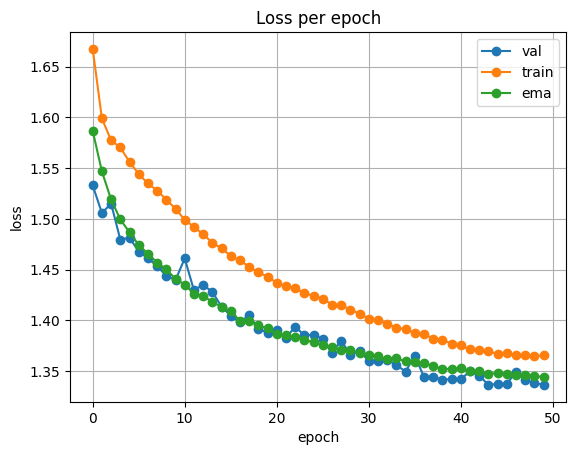

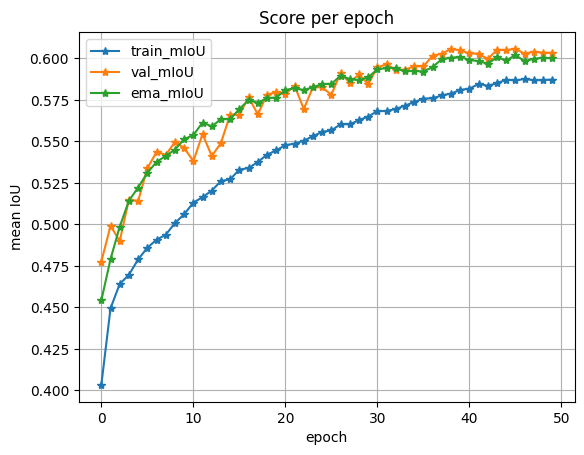

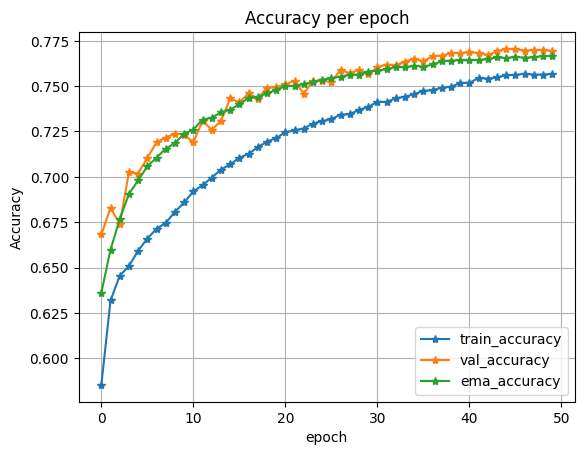

In [23]:
plot_loss(history)
plot_score(history)
plot_acc(history)

## Predict Result

預測`test`並將結果上傳至[**Kaggle**](https://www.kaggle.com/t/13040d09b42940ba90f96cca324ee90d)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「output.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中50%資料的正確率

In [24]:
TEST_IMAGE_PATH = 'BCSS/test/'

In [25]:
test_df = create_df(TEST_IMAGE_PATH)

In [26]:
X_test = test_df['id'].to_numpy()

In [36]:
model = torch.load('Unet-Mobilenet_v2_EMA_mIoU-best.pt')

In [37]:
class BCSSTestDataset(Dataset):
    
    def __init__(self, img_path, X, transform=None):
        self.img_path = img_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        return img

test_set = BCSSTestDataset(TEST_IMAGE_PATH, X_test)
print(len(test_set))

4021


In [38]:
def predict_image(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [39]:
import pandas as pd
from tqdm import tqdm

data = []

for i in tqdm(range(len(test_set))):
    img = test_set[i]
    pred_mask = predict_image(model, img)
    index = i 

    data.append({'index': index, 'pred_mask': pred_mask.numpy().tolist()})

df = pd.DataFrame(data)

df.to_csv('output.csv', index=False)

100%|██████████| 4021/4021 [01:31<00:00, 44.17it/s]
